# tvTAR1
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

In [1]:
import sys
sys.path.append('D:/ExperimentsPhD/June_19_24/wasslsp')
import warnings
warnings.filterwarnings('ignore')

import torch

import numpy as np
import scipy as scp

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import rc
#rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)

import seaborn as sns

from src.utils import *
from src.kernels import Kernel

from scipy.stats import wasserstein_distance
from mpl_toolkits.mplot3d import Axes3D

# Plot process

In [2]:
T = 1000
n_replications = 1
d = 1


phi1 = lambda u: 0.8 + 0.2 * np.sin(2 * np.pi * u)  
phi2 = lambda u: 0.4 + 0.3 * np.cos(2 * np.pi * u)  
tau = lambda u: 0.0  # Constant threshold
sigma_star = lambda u: 1.0

# Generate m_star
m_star = lambda u, x: phi1(u) * x if x <= tau(u) else phi2(u) * x

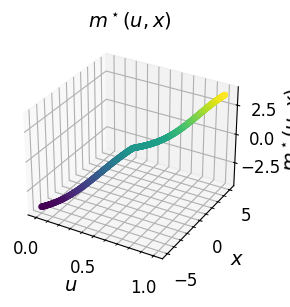

In [3]:
# Plot of m^star
plt.rcParams['text.usetex'] = False

# Create a mesh grid for u and x
u = np.linspace(0., 1., T)
x = np.linspace(-5, 5, T)
u_mesh, x_mesh = np.meshgrid(u, x)

# Compute m_star values for the mesh grid
m_star_vals_mesh = np.array([m_star(u_val, x_val) for u_val, x_val in zip(np.ravel(u_mesh), np.ravel(x_mesh))])
m_star_vals_mesh = m_star_vals_mesh.reshape(u_mesh.shape)

# Compute m_star values for plotting
m_star_vals = np.array([m_star(u_val, x_val) for u_val, x_val in zip(u, x)])

# Plotting
plt.rcParams["figure.figsize"] = (10, 3)
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.minorticks_on()
ax.scatter(u, x, m_star_vals, c=m_star_vals, cmap='viridis', linewidth=0.1)
ax.set_xlabel(r'$u$', fontsize=14)
ax.set_ylabel(r'$x$', fontsize=14)
ax.set_zlabel(r'$m^\star(u,x)$', fontsize=14)
ax.set_title(r'$m^\star(u,x)$', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:

T = 1000
n_replications = 1
d = 1


X_tvtar_1 = np.zeros(T)
X_tvtar_1_mean = np.zeros(T)

X_tvtar_1_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    t = 1
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvtar_1[t] = m_star((t/T), X_tvtar_1[t-1]) + sigma_star((t/T)) * epsilon[t]
        X[t] = [X_tvtar_1[t-1]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvtar_1_replications[replication] = X_tvtar_1

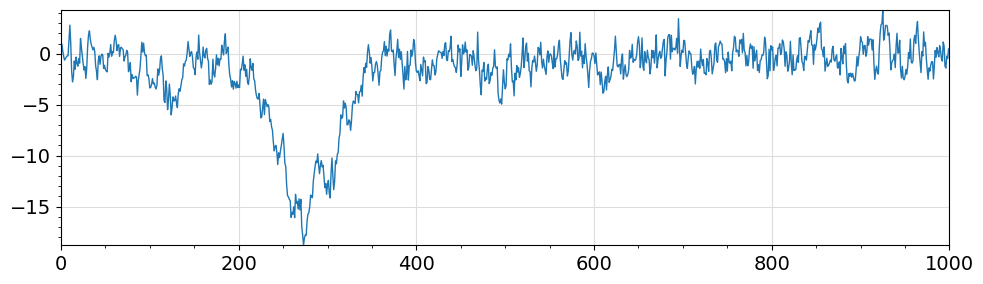

In [5]:
#path_fig = 'D:/ExperimentsPhD/Experiment results'
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.minorticks_on()
    plt.plot(X_tvtar_1_replications[replication], lw=1)
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    plt.ylim(min(X_tvtar_1_replications[replication]) , max(X_tvtar_1_replications[replication]))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    # plt.legend()
    plt.tight_layout()
    #plt.savefig(path_fig+"tv_AR_2_gaussian.pdf", dpi=300)

## NW estimator for the conditional mean function

Note that NW estimator of $m^\star(u,\boldsymbol{x})$ is given by  $\hat m(u,\boldsymbol{x}) 
% = \E_{\hat{\pi}_t(\cdot|\boldsymbol{x})}[Y_{t,T}| \boldsymbol{X}_{t,T}=\boldsymbol{x}]
= \sum_{a=1}^T   \omega_{a}(u, \boldsymbol{x}) Y_{a,T}$.

In [6]:
space_kernel = "gaussian"
time_kernel = "uniform"
bandwidth = T **(-0.4 / (2*(d+1)))
Y_t_T = X_tvtar_1_replications[0]

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

Kernel(T=1000, bandwidth=0.5011872336272722, time_kernel='uniform')

In [7]:
weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict['0'], t)

In [8]:
weights['0'].shape, Y_t_T.shape

((1000,), (1000,))

In [9]:
m_hat= [np.sum(weights[str(t)] * Y_t_T) for t in range(T)]
# for t in range(T): m_hat.append(np.sum(weights[str(t)] * Y_t_T))

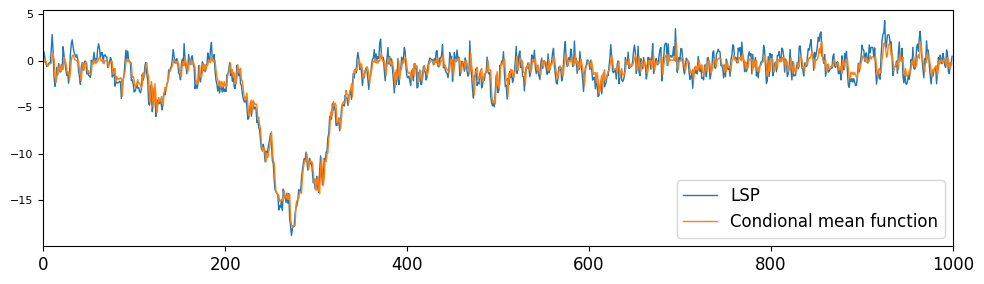

In [10]:
#path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvtar_1_replications[replication], lw=1, label="LSP")
    plt.plot(np.array(m_hat), lw=1, label="Condional mean function")
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

In [11]:
## Dimensions

In [12]:
times_T = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
times_t = [150, 200, 250, 300, 350, 400, 450, 500] 

d = 1
n_replications = 500

In [13]:

X_tvtar_1 = {}
X_tvtar_1_replications = {}
X_dict = {}

# "T:"+str(T
for T in times_T:
    X_tvtar_1_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [14]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=(T))
        X = np.zeros((T,d))
        X_tvtar_1_T = np.zeros(T)
        while t <= T-1 :
            X_tvtar_1_T[t] = m_star(t/T, X_tvtar_1_T[t-1]) + sigma_star(t/T) * epsilon[t]
            
            X[t] = [X_tvtar_1_T[t-1]]
            t += 1

        X_tvtar_1_replications[f"T:{T}"][replication] = X_tvtar_1_T
        X_dict[f"T:{T}"][str(replication)] = X


In [15]:
X_tvtar_1 = {}

for t in times_t:
    for T in times_T:
        X_tvtar_1[f"t:{t}_T:{T}"] = {}

# X_tvar_2

In [16]:
for t in times_t:
    for T in times_T:
        X_tvtar_1[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvtar_1_replications[f"T:{T}"][replication][t-1]
            X_tvtar_1[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvtar_1[f"t:{t}_T:{T}"] = np.array(X_tvtar_1[f"t:{t}_T:{T}"])

In [17]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvtar_1 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvtar_1[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvtar_1[f"t:{t}_T:{T}"])

        # sns.lineplot(
            # x=X_tvar_2[f"t:{t}_T:{T}"], y=norm_X_tvar_2[f"t:{t}_T:{str(T)}"], lw=2, markers=True,
            # label=f"(t,T)={t, T}",  drawstyle='steps-mid',          
        # )
        # plt.legend()
        # plt.tight_layout()

# Nadara-Watson estimator: Gaussian kernel

In [18]:
space_kernel = "gaussian"
time_kernel = "uniform"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi)
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [19]:
gaussian_kernel

{'T:1000': Kernel(T=1000, bandwidth=0.5011872336272722, time_kernel='uniform'),
 'T:2000': Kernel(T=2000, bandwidth=0.46762422391131064, time_kernel='uniform'),
 'T:3000': Kernel(T=3000, bandwidth=0.4490429419325431, time_kernel='uniform'),
 'T:4000': Kernel(T=4000, bandwidth=0.436308828551048, time_kernel='uniform'),
 'T:5000': Kernel(T=5000, bandwidth=0.42668070064464836, time_kernel='uniform'),
 'T:6000': Kernel(T=6000, bandwidth=0.4189718794398096, time_kernel='uniform'),
 'T:7000': Kernel(T=7000, bandwidth=0.41256292359026653, time_kernel='uniform'),
 'T:8000': Kernel(T=8000, bandwidth=0.4070905315369044, time_kernel='uniform'),
 'T:9000': Kernel(T=9000, bandwidth=0.4023238226562461, time_kernel='uniform'),
 'T:10000': Kernel(T=10000, bandwidth=0.3981071705534972, time_kernel='uniform')}

In [20]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [21]:
n_replications

500

In [22]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

\begin{align}
  \omega_{a}(\frac t T, \boldsymbol{x})=\frac{\displaystyle  K_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j- X_{a,T}^j)}{\displaystyle \sum_{a=1}^TK_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j - X_{a,T}^j)}.
 \end{align}

The associated conditional CDF to $\hat{\pi}_t(\cdot|\boldsymbol{x})$ is defined as, for all $y \in \R,$  
\begin{equation}
  \hat{F}_{t}(y|\boldsymbol{x})=\sum_{a=1}^T\omega_{a}(\frac tT,\boldsymbol{x}) \mathbf{1}_{Y_{a,T}\leq y}. %, \quad \text{for all $y\in\R$}. %  \ind{}(Y_{a,T}\leq y) 
\end{equation}


In [23]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvtar_1[f"t:{t}_T:{T}"])


In [24]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [25]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvtar_1_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvtar_1_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            #plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            #plt.xlabel(r'$y$')
            #plt.ylabel(r'$\hat{F}_t(y|x)$')
            ## plt.xticks(np.arange(0, T+1, 200, dtype=int))
            ##plt.xlim(-18, 18)
            #plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            #plt.legend()
            #plt.tight_layout()
            ##plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)
            

In [26]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [27]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [28]:
wass_distances_empirical_meanNW

{'t:150_T:1000': 0.36520904819243244,
 't:150_T:2000': 0.12072143366462298,
 't:150_T:3000': 0.09150771435762783,
 't:150_T:4000': 0.06126083374102777,
 't:150_T:5000': 0.05824899226502748,
 't:150_T:6000': 0.04195424930515295,
 't:150_T:7000': 0.05186971383627621,
 't:150_T:8000': 0.06708122485177145,
 't:150_T:9000': 0.06332105493084003,
 't:150_T:10000': 0.06289285818993136,
 't:200_T:1000': 0.507351294265781,
 't:200_T:2000': 0.1366759883527851,
 't:200_T:3000': 0.11059379247807219,
 't:200_T:4000': 0.09642419334359856,
 't:200_T:5000': 0.06546113978697325,
 't:200_T:6000': 0.07344379153779046,
 't:200_T:7000': 0.061006904485729624,
 't:200_T:8000': 0.046387503289374306,
 't:200_T:9000': 0.05700461385840122,
 't:200_T:10000': 0.053598603177853595,
 't:250_T:1000': 0.6366787280984674,
 't:250_T:2000': 0.23173510577884054,
 't:250_T:3000': 0.16494521033593731,
 't:250_T:4000': 0.07059667432543523,
 't:250_T:5000': 0.07507852644680132,
 't:250_T:6000': 0.06516470042690109,
 't:250_T:7

In [29]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

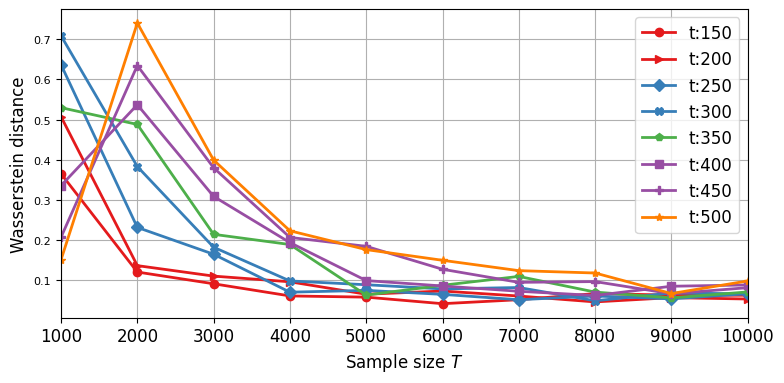

In [30]:

plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    #plt.title(r'Wasserstein distance $W_1\left(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\right)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)

# K1=tricube ; K2=silverman

In [31]:
space_kernel = "silverman"
time_kernel = "tricube"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) #/ 10
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [32]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [33]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [34]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvtar_1[f"t:{t}_T:{T}"])


In [35]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvtar_1_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvtar_1_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            #plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            #plt.xlabel(r'$y$')
            #plt.ylabel(r'$\hat{F}_t(y|x)$')
            ## plt.xticks(np.arange(0, T+1, 200, dtype=int))
            ##plt.xlim(-18, 18)
            #plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            #plt.legend()
            #plt.tight_layout()
            ##plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [36]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [37]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [38]:
wass_distances_empirical_meanNW

{'t:150_T:1000': 0.3616715728462577,
 't:150_T:2000': 0.11994684396919328,
 't:150_T:3000': 0.0891307210917286,
 't:150_T:4000': 0.06535171951019225,
 't:150_T:5000': 0.06136069785417731,
 't:150_T:6000': 0.04846771874922513,
 't:150_T:7000': 0.05027707165581478,
 't:150_T:8000': 0.07352800551778664,
 't:150_T:9000': 0.06704050201443146,
 't:150_T:10000': 0.06937905949716411,
 't:200_T:1000': 0.5010182811937479,
 't:200_T:2000': 0.13424194738013548,
 't:200_T:3000': 0.1082504233637522,
 't:200_T:4000': 0.09557086901485451,
 't:200_T:5000': 0.07048759145563174,
 't:200_T:6000': 0.07801796316152942,
 't:200_T:7000': 0.06434772909107517,
 't:200_T:8000': 0.04770350243433019,
 't:200_T:9000': 0.05767657763580494,
 't:200_T:10000': 0.058490471827316565,
 't:250_T:1000': 0.6294672838946354,
 't:250_T:2000': 0.22919886391798353,
 't:250_T:3000': 0.16176304753407147,
 't:250_T:4000': 0.07330884015124967,
 't:250_T:5000': 0.07819947470772645,
 't:250_T:6000': 0.06702011634954368,
 't:250_T:7000

In [39]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

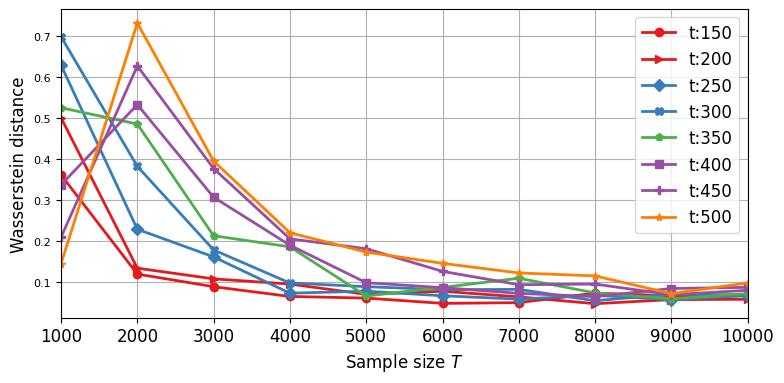

In [40]:

plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    #plt.title(r'Wasserstein distance $W_1\left(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\right)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)